# Recent Signal Lab

Single notebook for symbols with recent `tiered_candidate_25_early_50` signals.
Set `SYMBOL` in the code cell to switch charts.


Recent signal symbols: ['CL', 'GE', 'IBN', 'OKE', 'TGT', 'VCSH', 'VGK']
Rows loaded: 786
Plot window: 2023-02-21 -> 2026-02-20
Tier transitions in window: 52
Executed actions in window: 40


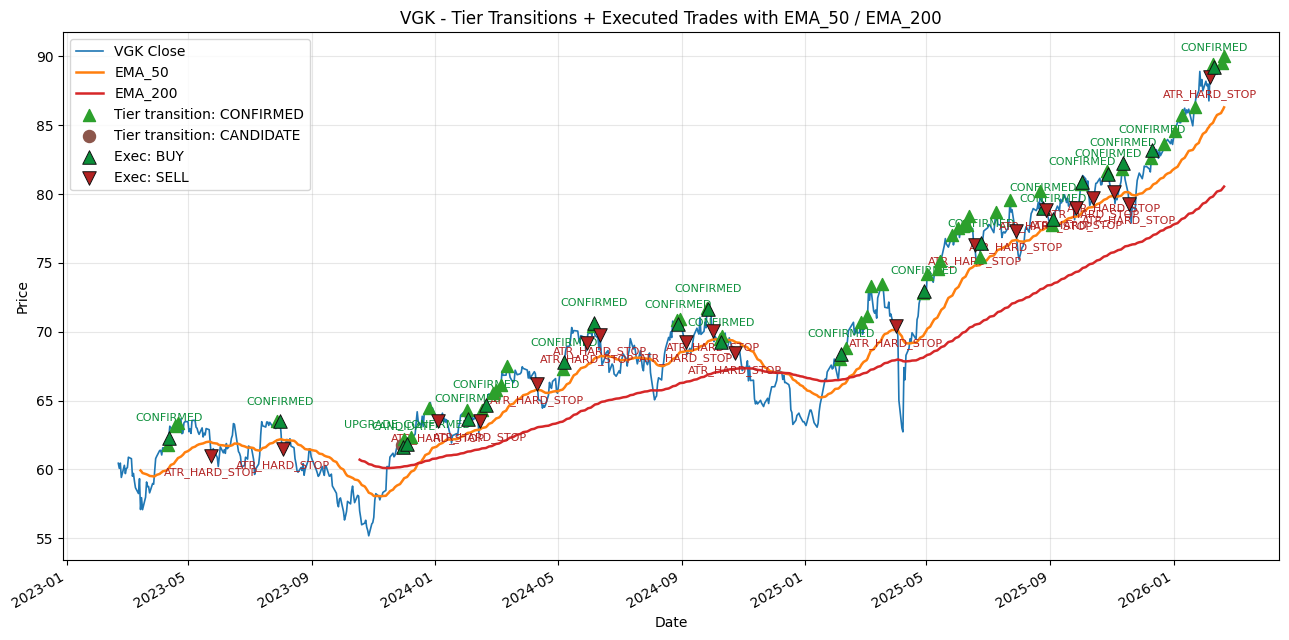


Recent 5 bars with tier signal:
  2026-02-18  tier=CONFIRMED  alloc=1.0  breakout=1  reclaim=0  wk=1  m=1  m_early=1
  2026-02-20  tier=CONFIRMED  alloc=1.0  breakout=1  reclaim=0  wk=1  m=1  m_early=1


In [1]:
from pathlib import Path
import csv
from datetime import date, timedelta
import matplotlib.pyplot as plt

SYMBOL = "VGK"  # Change this to any symbol in RECENT_SIGNAL_SYMBOLS
YEARS_TO_PLOT = 3
RECENT_WINDOW_BARS = 5


def resolve_repo_root() -> Path:
    candidates = [Path.cwd(), Path.cwd().parent]
    for candidate in candidates:
        if (candidate / "out").exists():
            return candidate
    raise FileNotFoundError("Could not locate repo root containing out/")


def compute_ema(values: list[float], period: int) -> list[float | None]:
    out: list[float | None] = [None] * len(values)
    if period <= 0 or len(values) < period:
        return out
    alpha = 2.0 / (period + 1.0)
    seed = sum(values[:period]) / period
    out[period - 1] = seed
    prev = seed
    for idx in range(period, len(values)):
        curr = (values[idx] - prev) * alpha + prev
        out[idx] = curr
        prev = curr
    return out


def read_rows(path: Path) -> list[dict[str, str]]:
    with path.open("r", encoding="utf-8", newline="") as handle:
        rows = list(csv.DictReader(handle))
    if not rows:
        raise ValueError(f"No rows in {path}")
    return rows


repo = resolve_repo_root()
strategy_dir = repo / "out" / "entry_tier_experiment" / "tiered_candidate_25_early_50"

all_strategy_files = sorted(strategy_dir.glob("*.csv"))
if not all_strategy_files:
    raise FileNotFoundError(f"No strategy files found in {strategy_dir}")

recent_signal_symbols: list[str] = []
for csv_path in all_strategy_files:
    rows = read_rows(csv_path)
    last_rows = rows[-RECENT_WINDOW_BARS:]
    has_signal = any((r.get("TierSignal") or "").strip() not in {"", "NONE"} for r in last_rows)
    if has_signal:
        recent_signal_symbols.append(csv_path.stem)

RECENT_SIGNAL_SYMBOLS = sorted(recent_signal_symbols)
print("Recent signal symbols:", RECENT_SIGNAL_SYMBOLS)

if SYMBOL not in RECENT_SIGNAL_SYMBOLS:
    raise ValueError(
        f"SYMBOL={SYMBOL} is not in RECENT_SIGNAL_SYMBOLS={RECENT_SIGNAL_SYMBOLS}. "
        "Set SYMBOL to one of these values."
    )

strategy_csv = strategy_dir / f"{SYMBOL}.csv"
daily_csv = repo / "out" / "daily" / f"{SYMBOL}.csv"

if not strategy_csv.exists():
    raise FileNotFoundError(f"Missing strategy file: {strategy_csv}")
if not daily_csv.exists():
    raise FileNotFoundError(f"Missing daily file: {daily_csv}")

rows = read_rows(strategy_csv)
rows.sort(key=lambda r: r["Date"])

dates = [date.fromisoformat(r["Date"]) for r in rows]
closes = [float(r["Close"]) for r in rows]
ema50 = compute_ema(closes, 50)
ema200 = compute_ema(closes, 200)

# Plot only transitions into a new non-NONE tier to reduce chart noise.
tier_transitions: list[tuple[int, str]] = []
prev_tier = "NONE"
for idx, r in enumerate(rows):
    tier = (r.get("TierSignal") or "").strip() or "NONE"
    if tier != "NONE" and tier != prev_tier:
        tier_transitions.append((idx, tier))
    prev_tier = tier

executed = [
    (idx, (r.get("ExecutedAction") or "").strip(), (r.get("ExecutedReason") or "").strip())
    for idx, r in enumerate(rows)
]
executed = [(idx, action, reason) for idx, action, reason in executed if action]

start_date = dates[-1] - timedelta(days=365 * YEARS_TO_PLOT)
start_idx = next((i for i, d in enumerate(dates) if d >= start_date), 0)

plot_dates = dates[start_idx:]
plot_close = closes[start_idx:]
plot_ema50 = ema50[start_idx:]
plot_ema200 = ema200[start_idx:]
window_tier_transitions = [(i, s) for i, s in tier_transitions if i >= start_idx]
window_exec = [(i, a, r) for i, a, r in executed if i >= start_idx]

print(f"Rows loaded: {len(rows)}")
print(f"Plot window: {plot_dates[0]} -> {plot_dates[-1]}")
print(f"Tier transitions in window: {len(window_tier_transitions)}")
print(f"Executed actions in window: {len(window_exec)}")

fig, ax = plt.subplots(1, 1, figsize=(13, 6.5))
ax.plot(plot_dates, plot_close, color="#1f77b4", linewidth=1.2, label=f"{SYMBOL} Close")
ax.plot(plot_dates, plot_ema50, color="#ff7f0e", linewidth=1.8, label="EMA_50")
ax.plot(plot_dates, plot_ema200, color="#d62728", linewidth=1.8, label="EMA_200")

tier_style = {
    "CANDIDATE": {"color": "#8c564b", "marker": "o"},
    "EARLY_CONFIRM": {"color": "#9467bd", "marker": "^"},
    "CONFIRMED": {"color": "#2ca02c", "marker": "^"},
}
seen = set()
for idx, tier in window_tier_transitions:
    style = tier_style.get(tier, {"color": "#7f7f7f", "marker": "o"})
    row_date = dates[idx]
    y = closes[idx]
    label = f"Tier transition: {tier}" if tier not in seen else "_nolegend_"
    seen.add(tier)
    ax.scatter([row_date], [y], color=style["color"], marker=style["marker"], s=75, label=label, zorder=6)

exec_seen = set()
for idx, action, reason in window_exec:
    row_date = dates[idx]
    y = closes[idx]
    if action in {"BUY", "SCALE_IN"}:
        color, marker, name, offset = "#0b8f3a", "^", "BUY", 12
    elif action == "SELL":
        color, marker, name, offset = "#b22222", "v", "SELL", -14
    else:
        color, marker, name, offset = "#333333", "x", action, 12
    label = f"Exec: {name}" if name not in exec_seen else "_nolegend_"
    exec_seen.add(name)
    ax.scatter([row_date], [y], color=color, marker=marker, s=95, edgecolors="#111111", linewidths=0.7, label=label, zorder=8)
    if reason:
        ax.annotate(reason, (row_date, y), textcoords="offset points", xytext=(0, offset), ha="center", fontsize=8, color=color)

ax.set_title(f"{SYMBOL} - Tier Transitions + Executed Trades with EMA_50 / EMA_200")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(alpha=0.3)
ax.legend(loc="best")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

print("")
print("Recent 5 bars with tier signal:")
last5 = rows[-RECENT_WINDOW_BARS:]
found = False
for r in last5:
    tier = (r.get("TierSignal") or "").strip()
    if tier and tier != "NONE":
        found = True
        print(
            f"  {r['Date']}  tier={tier}  alloc={r.get('DesiredAlloc','')}  "
            f"breakout={r.get('DailyBreakout','')}  reclaim={r.get('PullbackReclaim','')}  "
            f"wk={r.get('WeeklyRiskOn','')}  m={r.get('MonthlyRiskOn','')}  m_early={r.get('MonthlyEarlyOn','')}"
        )
if not found:
    print("  none")
